In [5]:
!pip install matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
! pip install transformer


ERROR: Could not find a version that satisfies the requirement transformer (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for transformer


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Saved combined result to D:\braintumor\brain-t\combined_result.png


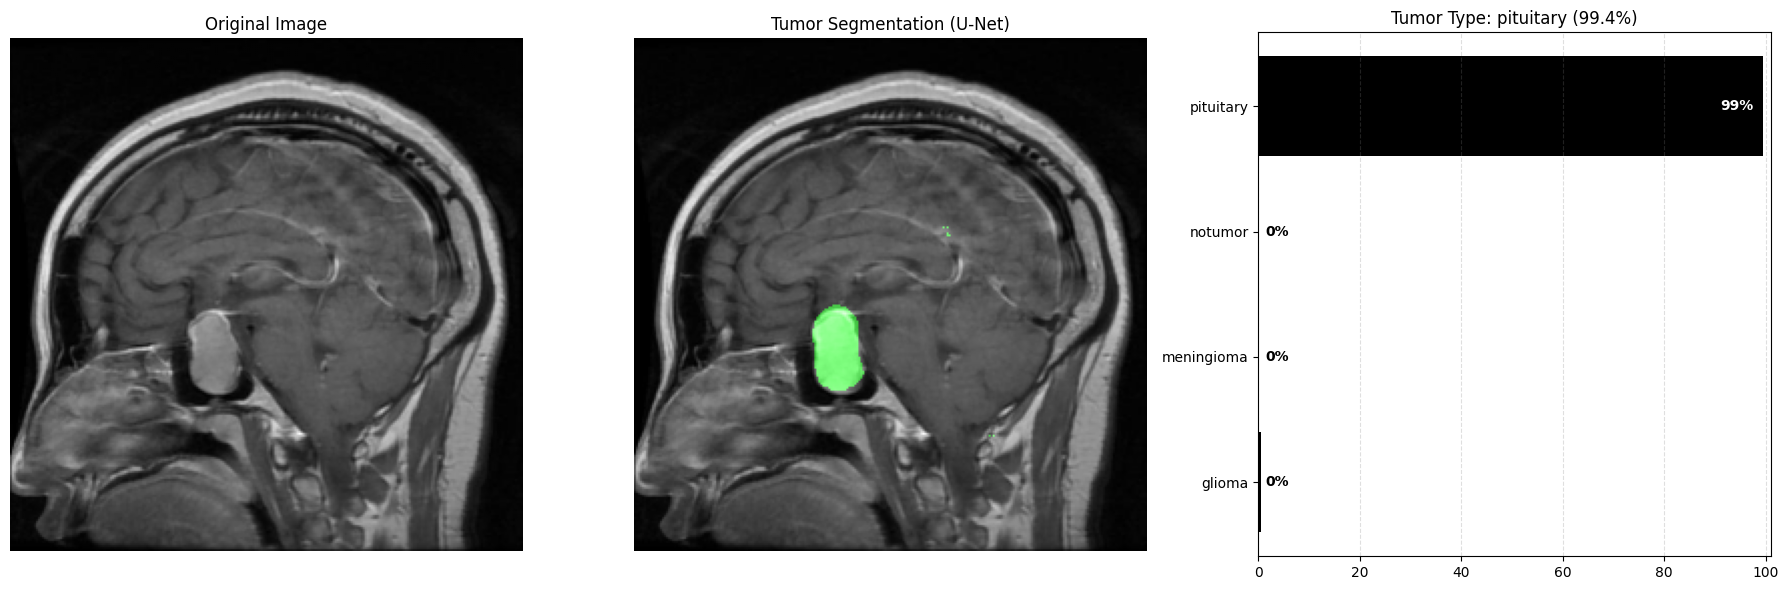

In [16]:
# ------------------ IMPORTS ------------------
import os
import numpy as np
import cv2
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from patchify import patchify
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from transformer import TumorClassifierViT  # Your custom ViT model

# ------------------ CONFIG ------------------
# U-Net config
cf = {
    "image_size": 256,
    "num_channels": 3,
    "patch_size": 16,
}
cf["num_patches"] = (cf["image_size"]**2) // (cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"] * cf["patch_size"] * cf["num_channels"]
)

# PyTorch device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------ U-Net Dice Metrics ------------------
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# ------------------ U-Net Preprocessing ------------------
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    image = image / 255.0
    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(image, patch_shape, cf["patch_size"])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    patches = patches.astype(np.float32)
    patches = np.expand_dims(patches, axis=0)
    return image, patches

def overlay_mask_on_image(image, mask, alpha=0.5, color=(0, 255, 0)):
    image = (image * 255).astype(np.uint8)
    mask = (mask * 255).astype(np.uint8)
    mask_colored = np.zeros_like(image, dtype=np.uint8)
    mask_colored[:, :, 1] = mask
    blended = cv2.addWeighted(image, 1.0, mask_colored, alpha, 0)
    return blended

# ------------------ Classification Functions ------------------
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

    confidence, predicted = torch.max(probabilities, 0)
    return predicted.item(), confidence.item(), probabilities.cpu().numpy(), image

# ------------------ Display Combined Output ------------------
def display_results(original_image, mask_overlay, predicted_class, confidence, probabilities, class_names, save_path):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(original_image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(mask_overlay)
    axs[1].set_title("Tumor Segmentation (U-Net)")
    axs[1].axis('off')

    rects = axs[2].barh(range(len(class_names)), [x*100 for x in probabilities], color='black')
    axs[2].set_yticks(range(len(class_names)))
    axs[2].set_yticklabels(class_names)
    axs[2].set_xlim([0, 101])
    axs[2].set_title(f"Tumor Type: {class_names[predicted_class]} ({confidence*100:.1f}%)")
    axs[2].xaxis.grid(True, linestyle='--', color='gray', alpha=0.25)

    for rect in rects:
        width = int(rect.get_width())
        label = f"{width}%"
        xloc = 5 if width < 40 else -5
        align = 'left' if width < 40 else 'right'
        color = 'black' if width < 40 else 'white'
        yloc = rect.get_y() + rect.get_height() / 2
        axs[2].annotate(label, (width, yloc), xytext=(xloc, 0),
                        textcoords="offset points", ha=align, va='center', color=color, weight='bold')

    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Saved combined result to {save_path}")
    plt.show()

# ------------------ MAIN ------------------
if __name__ == "__main__":
    # ---- Paths ----
    keras_model_path = "D:\\hirmuzesh\\best_model(1).keras"
    pytorch_model_path = "D:\\braintumor\\brain-t\\best_model.pth"
    image_path = "D:\\hirmuzesh\\vit-brain-tumor\\archive\\Training\\pituitary\\Tr-pi_0024.jpg"
    class_folder = "D:\\braintumor\\brain-t\\archive\\Training"
    output_path = "D:\\braintumor\\brain-t\\combined_result.png"

    # ---- Load Models ----
    unet_model = tf.keras.models.load_model(
        keras_model_path, custom_objects={"dice_loss": dice_loss, "dice_coef": dice_coef})

    vit_model = TumorClassifierViT(num_classes=4)
    vit_model.load_state_dict(torch.load(pytorch_model_path))
    vit_model.to(device)
    vit_model.eval()

    # ---- Preprocess and Predict ----
    input_image, input_patches = load_and_preprocess_image(image_path)
    pred_mask = unet_model.predict(input_patches)[0]
    pred_mask = cv2.resize(pred_mask, (cf["image_size"], cf["image_size"]))
    pred_mask = np.where(pred_mask > 0.5, 1.0, 0.0)

    overlayed_image = overlay_mask_on_image(input_image, pred_mask)

    predicted_class, confidence, probabilities, pil_image = predict_image(
        image_path, vit_model, data_transforms, device)

    # ---- Class Names ----
    train_dataset = ImageFolder(class_folder, transform=data_transforms)
    class_names = train_dataset.classes

    # ---- Display Combined Output ----
    display_results(input_image, overlayed_image, predicted_class, confidence, probabilities, class_names, output_path)
